# 4장 모델 훈련

**기본설정**

파이썬 3.7 이상을 요구한다.

In [1]:
import sys

assert sys.version_info >= (3, 7)

사이킷런 1.0.1 이상을 요구한다.

In [2]:
import sklearn

assert sklearn.__version__ >= "1.0.1"

다음은 이미지에 포함된 폰트 크기를 설정한다.

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## 4.1. 선형 회귀

선형 회귀 모델을 구현하는 과정을 살펴본다.

아래 코드는 선형 회귀 모델 훈련에 사용될 데이터 100개를 생성한다. 
`y = 4 + 3 * X ` 1차 함수를 모델로 하는 데이터이며
약간의 잡음이 추가된다. 

In [4]:
import numpy as np

np.random.seed(42)                     # 무작위성 지정

m = 100                                # 데이터셋 크기

X = 2 * np.random.rand(m, 1)           # 입력 데이터셋: 0에서 2 사이의 임의의 값 100개.
y = 4 + 3 * X + np.random.randn(m, 1)  # y = 4 + 3*X 함수를 이용한 타깃값 생성. 잡음 추가됨.

데이터를 산점도로 그리면 잡음 때문에 일직선이 아니
선형적으로 퍼져 있는 데이터를 볼 수 있다.

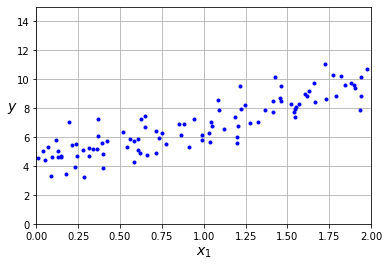

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

### 4.1.1. 정규  방정식

$x_1$ 과 $y$ 사이의 관계를 가장 잘 표현하는 직선은 수학적으로 정확하게 구할 수 있다.
즉, 아래 식을 가장 잘 충족시키는 파라미터 벡터 $\theta$를 수학적으로 계산할 수 있다.

$$
\mathbf y = \mathbf{X}\, \mathbf{\theta}
$$

**(참고) `np.linalg.inv()` 함수**

역행렬이 존재하는 경우 `np.linalg.inv()` 함수가 역행렬을 계산한다.
아래 코드는 아래 식을 구현한다.
`theta_best` 가 $\hat{\mathbf{\theta}}$ 에 해당한다.

$$
\hat{\mathbf{\theta}} = 
(\mathbf{X}^T\, \mathbf{X})^{-1}\, \mathbf{X}^T\, \mathbf{y}
$$

In [6]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)   # 절편과의 곱을 위해 필요한 1 추가
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

절편은 4.225로, 기울기는 2.77 정도로 계산된다.

In [7]:
theta_best

array([[4.21509616],
       [2.77011339]])

정규 방정식으로 구해진 1차 함수의 적절성을 아래 그래프로 확인할 수 있다.
먼저 직선상에 위치한 두 점을 확인한다. 
이를 위해 찾아진 절편과 기울기를 이용한다.

In [8]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # 절편과의 곱을 위한 1 추가.

y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

찾은 최적의 직선과 훈련 데이터의 산점도를 함께 그린다.

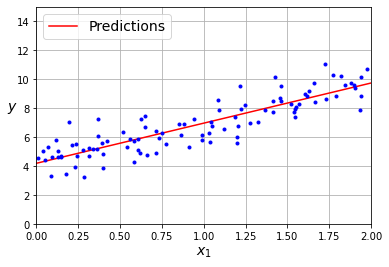

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")

# extra code – beautifies and saves Figure 4–2
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

### 4.1.2. `LinearRegression` 클래스

사이킷런의 `LinearRegression` 모델 또한 정규 방정식을 이용하여 
절편과 기울기를 계산한다.

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

# 절편과 기울기
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

예측은 `predict()` 메서드를 이용한다. 

In [11]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

**(참고) `scipy.linalg.lstsq()` 함수**

`fit()` 메서드는 `scipy.linalg.lstsq()` 함수를 이용한다.

In [12]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

**(참고) `np.linalg.pinv()` 함수** 

`scipy.linalg.lstsq()` 함수는 $\mathbf{X}^+\mathbf{y}$ 를 계산한다.
$\mathbf{X}^{+}$ 는 무어-펜로즈 유사 역행렬이며, `np.linalg.pinv()` 함수가
이를 계산한다.

In [13]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

## 4.2. 경사 하강법

### 4.2.1. 선형 회귀 모델과 경사 하강법

아래 코드는 선형 회귀 모델에 대해 적용하는 배치 경사 하강법을 
순수 파이썬 코드로 구현한다. 

In [14]:
eta = 0.1                            # 학습률
n_epochs = 1000                      # 에포크 수
m = len(X_b)                         # 훈련셋 크기

np.random.seed(42)

theta = np.random.randn(2, 1)        # 임의로 초기화된 파라미터. (2, 1) 모양의 어레이

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)  # MSE의 그레이디언트
    theta = theta - eta * gradients                # 파라미터 업데이트

모델 훈련 결과 파라미터가 적절한 기울기와 편차로 수렴한다.

In [15]:
theta

array([[4.21509616],
       [2.77011339]])

### 4.2.2. 경사 하강법 종류

#### 4.2.2.1. 배치 경사 하강법 종류

**학습률과 경사 하강법의 관계**

아래 코드는 학습률에 따라 파라미터의 수렴 여부와 속도가 달라짐을 보여준다.

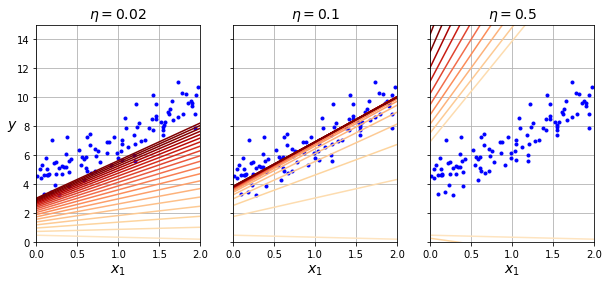

In [16]:
import matplotlib as mpl

# 아래 그래프를 그리는 함수
# 학습률이 지정되었을 때, 파라미터 수렴 과정을 직선의 수렴과정으로 그림.
def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    
    n_epochs = 1000  # 에포크 수
    
    n_shown = 20     # 아래 그래프에서 보이는 20개의 그래프 그리기 용도
    
    theta_path = []  # 훈련 과정동안 업데이트 되는 파라미터 수렴 과정 확인 용도
    
    # 경사 하강법 1000번 반복
    for epoch in range(n_epochs):
        # 첫 20개의 파라미터 업데이트 확인용 직선 그리기
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
            
        # 경사 하강법
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        
        # 학습괸 파라미터 저장 
        theta_path.append(theta)
        
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path                # 저장된 파라미터 어레이 반환

np.random.seed(42)
theta = np.random.randn(2, 1)  # 파라미터 무작위 초기화

plt.figure(figsize=(10, 4))

# 학습률: 0.02 
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)

# 학습률: 0.1 
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)  # 반환값은 이어지는 그래프에서 활용됨.
plt.gca().axes.yaxis.set_ticklabels([])

# 학습률: 0.5
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)

plt.show()

#### 4.2.2.2. 확률적 경사 하강법

아래 코드는 확률적 경사 하강법을 직접 구현한다.

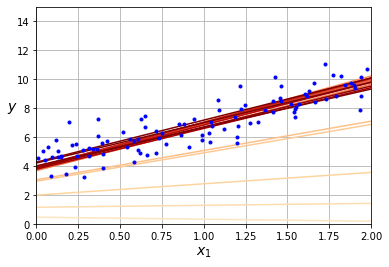

In [17]:
theta_path_sgd = []  # 확률적 경사하강법으로 학습되는 파라미터 추적 용도

n_epochs = 50        # 에포크: 50

# 학습 스케줄 함수: 학습률을 점차 줄어들게 함.
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # 파라미터 무작위 초기화

n_shown = 20                   # 첫 20개의 파라미터 업데이트 확인용 직선 그리기
plt.figure(figsize=(6, 4))     # 그래프 포매팅 

# 1000번 경사하강법 적용
for epoch in range(n_epochs):
    for iteration in range(m):

        # 첫 20개의 직선 그리기 용도
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        # 무작위 샘플 선택 (확률적)
        random_index = np.random.randint(m)        # 무작위 인덱스 선택
        
        xi = X_b[random_index : random_index + 1]  # 길이가 1인 2차원 어레이. 
        yi = y[random_index : random_index + 1]
        
        gradients = 2 * xi.T @ (xi @ theta - yi)  # 그레이디언트. m = 1.
        
        # 학습률 조정: 학습 스케줄 활용
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        
        # 학습된 파라미터 저장
        theta_path_sgd.append(theta)  # 그래프 그리기 용도

plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

훈련 결과로 얻어진 파라미터(기울기와 절편)는 다음과 같다.

In [18]:
theta

array([[4.21076011],
       [2.74856079]])

**사이킷런의 `SGDRegressor` 클래스**

`SGDRegressor` 클래스가 확률적 경사 하강법을 지원한다.
이 경우 타깃 어레이는 1차원이어야 함에 주의하라.

In [19]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)

sgd_reg.fit(X, y.ravel())  # y.ravel(): 타깃값을 1차원 어레로 변환

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

최종 결과는 이전과 거의 동일하다.
절편은 `intercept_` 인스턴스 속성에, 기울기는 `coef_` 인스턴스 속성에 저장된다.

In [20]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

#### 4.2.2.3. 미니 배치 경사 하강법

미니 배치 경사 하강법을 직접 구현한다.
또한 배치, 확률적, 미니 배치 경사 하강법 각각의 경우에
파라미터의 수렴 과정을 그림으로 그려준다.

In [21]:
from math import ceil

n_epochs = 50         # 에포크 수
minibatch_size = 20   # 미니 배치 크기

n_batches_per_epoch = ceil(m / minibatch_size)  # 스텝 수

np.random.seed(42)
theta = np.random.randn(2, 1)  # 파라미터 무작위 초기화

# 학습 스케줄
t0, t1 = 200, 1000

def learning_schedule(t):
    return t0 / (t + t1)

# 미니 배치의 파라미터 수렴 과정
theta_path_mgd = []

# 미니 배치 경사 하강법 훈련
for epoch in range(n_epochs):
    
    # 무작위 섞기
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    
    # 미니 배치 경사 하강법 반복
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]  # 미니 배치 묶음
        yi = y_shuffled[idx : idx + minibatch_size]
        
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi) # 그레이디언트
        eta = learning_schedule(iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

**경사 하강법 비교**

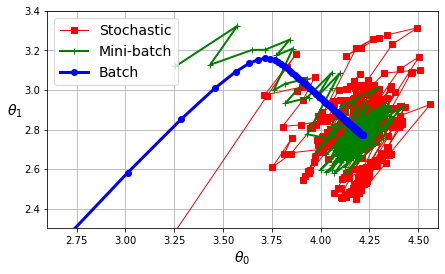

In [22]:
# 아래 그래프 그리기
# 세 종류의 경사 하강법에서 파라미터가 수렴하는 과정을 보여줌.

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2,
         label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3,
         label="Batch")
plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$   ", rotation=0)
plt.axis([2.6, 4.6, 2.3, 3.4])
plt.grid()
plt.show()

## 4.3 다항 회귀

비선형 데이터를 대상으로 다항회귀를 적용한다.
먼저 2차 함수의 그래프 형식으로 분포된 데이터셋을 생성한다.

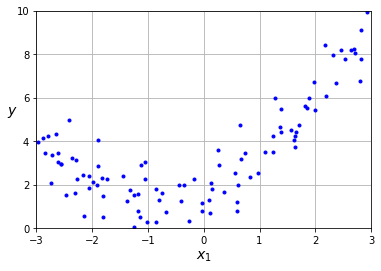

In [23]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3                   # -3에서 3 사이의 임의의 값 100개
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)   # 2차 함수 활용. 잡음 추가됨.

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

**2차 함수 모델를 따르는 데이터셋에 2차 다항식 모델 적용 결과**

**사이킷런의 `PolynomialFeatures` 변환기**

지정된 차수까지 필요한 고차항을 새로운 특성으로 추가한다.

In [24]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

$x_1^2$ 에 해당하는 특성 $x_2$ 가 추가된다.

In [25]:
X[0]  # [x1]

array([-0.75275929])

In [26]:
X_poly[0]  # [x1, x2]

array([-0.75275929,  0.56664654])

이제 선형 회귀 모델을 적용하면 적절한 절편 $\theta_0$ 과 가중치$\theta_1$ 과 $\theta_2$ 를 얻는다.

-  `intercept_` 인스턴스 변수: 절편 $\theta_0$
- `coef_` 인스턴스 변수: 가중치 $\theta_1$ 과 $\theta_2$ 

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

모델을 시각화하면 훈련 데이터셋을 잘 반영하는 2차 함수의 그래프가 그려진다.

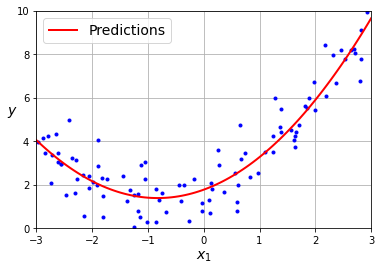

In [28]:
# 2차 함수 그래프 그리기
X_new = np.linspace(-3, 3, 100).reshape(100, 1)  # x1 값: -3에서 3 사이를 100등분해서 얻어지는 값.
X_new_poly = poly_features.transform(X_new)      # x1**2 추가
y_new = lin_reg.predict(X_new_poly)              # 예측 타깃값

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")  # 2차 함수 그래프
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

## 4.4 학습 곡선

(참고) 아래 그림은 1차, 2차, 300차 다항 회귀의 결과를 보여준다.

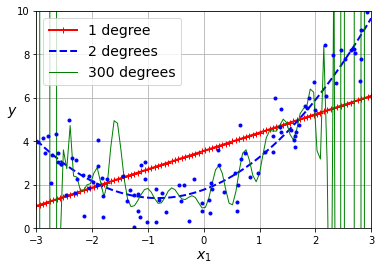

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

# 1차, 2차, 300차 다항 회귀 모델 계산
for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    # 고차 항 추가
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    
    # 변환 파이프라인
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    
    # 선형 회귀 모델 계산
    polynomial_regression.fit(X, y)
    
    # 모델별 예측값 
    y_newbig = polynomial_regression.predict(X_new)
    
    # 그래프 그리기
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

**과소 적합 모델의 학습 곡선 특징**

`learning_curve()` 함수는 학습 곡선를 그리는 데에 필요한
훈련셋의 크기, 훈련 점수, 검증 점수를 계산한다. 

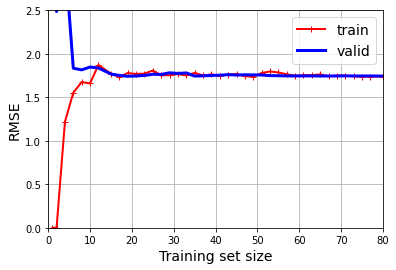

In [30]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, 
    train_sizes=np.linspace(0.01, 1.0, 40),  # 훈련셋 크기: 0.01 % 에서 전체까지 0.25% 씩 증가시킴
    cv=5,                                    # 교차 검증
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not need, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])

plt.show()

**과대 적합 모델의 학습 곡선 특징**

과대 적합 모델은 다른 모양의 학습 곡선을 생성한다. 
아래 코드는 주어진 2차 함수 모델의 데이터셋에 
10차 다항 회귀를 사용하면 전형적인 과대 적합 현상이 발생함을 보여준다.

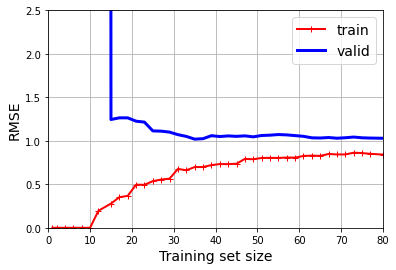

In [31]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression() )

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, 
    train_sizes=np.linspace(0.01, 1.0, 40), 
    cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
plt.show()

## 4.5 규제 사용 선형 모델

### 4.5.1. 릿지 회귀

20 개의 샘플로 구성된 훈련셋을 생성한다. 
`y = 1 + 0.5 X` 1차 함수를 따르도록 하지만 잡믕의 영향을 많이 받게 한다.

In [32]:
# extra code – we've done this type of generation several times before
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5   # 잡음의 영향을 크게 줌.

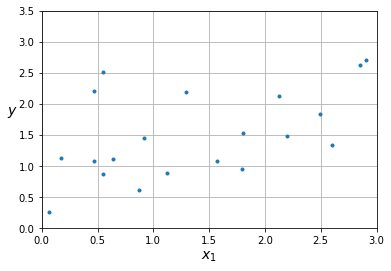

In [33]:
# extra code – a quick peek at the dataset we just generated
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

**`Ridge` 클래스**

릿지 규제를 사용하는 선형 회귀 모델이다.

- `"cholesky"` 솔버: 정규 방정식 활용

In [34]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")

**(참고) 릿지 회귀 규제 강도**

아래 코드는 규제 강도를 가리키는 `alpha` 값을 다양하게 할 때의 차이점을 그래프로 보여준다.

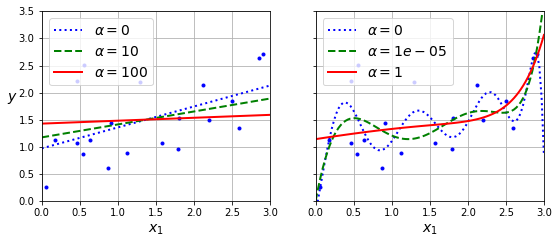

In [35]:
# 그래프 그리기 용도의 x1 값
X_new = np.linspace(0, 3, 100).reshape(100, 1)  # 0에서 3사이를 100등분한 값

# 아래 함수는 alpha 값에 따라 릿지 회귀 또는 기본 선형회귀 모델을 실행하며,
# 다항 회귀를 사용하느냐에 따라 전처리 과정을 포함하기도 한다.
# 또한 실행 결과로 얻어진 모델을 그래프로 그린다.

def plot_model(model_class, polynomial, alphas, **model_kargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))

# 왼쪽 그래프
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)         # y축 레이블 지정

# 오른쪽 그래프
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])  # y축 레이블 없애기

plt.show()

**`SGDRegressor` 클래스와 릿지 규제**

`SGDRegressor` 모델에 릿지 규제를 가하는 방식은 다음과 같다.

- `alpha`: 훈련셋 크기에 반비례하도록 함. 아래 `Ridge` 모델의 경우와 비교할 것.

In [36]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_reg.fit(X, y.ravel())   # y.ravel(): 타깃값을 1차원 어레로 변환
sgd_reg.predict([[1.5]])

array([1.55302613])

위 모델과 가장 유사한 `Ridge` 모델은 다음과 같다.

- `"sag"` 솔버: 확률적 경사 하강법 지원
- `alpha` 값: `SGDRegressor`의 경우와 다름.

In [37]:
ridge_reg = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55321535]])

**(참고) `"cholesky"` 솔버**

`"cholesky"` 솔버는 `np.linalg.inv()` 함수를 이용하여 역함수를 이용하여
최적의 파라미터를 계산한다.

In [38]:
alpha = 0.1
A = np.array([[0., 0.], [0., 1.]])
X_b = np.c_[np.ones(m), X]
np.linalg.inv(X_b.T @ X_b + alpha * A) @ X_b.T @ y

array([[0.97898394],
       [0.3828496 ]])

`Ridge` 모델이 찾은 파라미터와 거의 동일하다.

In [39]:
ridge_reg.intercept_, ridge_reg.coef_ 

(array([0.97944909]), array([[0.38251084]]))

### 4.5.2. 라쏘 회귀

**`Lasso` 클래스**

라쏘 규제를 사용하는 선형 회귀 모델이다.

In [40]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

**`SGDRegressor` 클래스와 라쏘 규제**

`SGDRegressor` 모델에 라쏘 규제를 가하는 방식은 다음과 같다.

In [41]:
sgd_reg = SGDRegressor(penalty="l1", alpha=0.1, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_reg.fit(X, y.ravel())   # y.ravel(): 타깃값을 1차원 어레로 변환
sgd_reg.predict([[1.5]])

array([1.53728962])

**(참고) 라쏘 회귀 규제 강도**

아래 코드는 규제 강도를 가리키는 `alpha` 값을 다양하게 할 때의 차이점을 그래프로 보여준다.

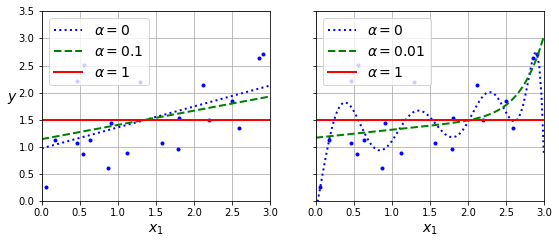

In [42]:
# extra code – this cell generates and saves Figure 4–18
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

### 4.5.3. 엘라스틱 넷

**`ElasticNet` 클래스**

엘라스틱 모델을 구현한 클래스다.

In [43]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

**`SGDRegressor` 클래스와 엘라스틱 넷**

`SGDRegressor` 모델에 엘라스틱 넷처럼 작동하는 방식은 다음과 같다.

In [44]:
sgd_reg = SGDRegressor(penalty="elasticnet", alpha=0.1, tol=None, l1_ratio=0.5,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_reg.fit(X, y.ravel())   # y.ravel(): 타깃값을 1차원 어레로 변환
sgd_reg.predict([[1.5]])

array([1.54296004])

### 4.5.4. 조기 종료

아래 코드는 조기 종료 기법을 이용하여 최적의 모델을 찾는다.

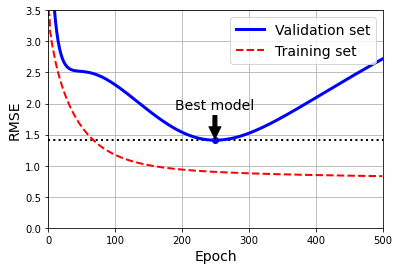

In [45]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 100개의 샘플로 구성된 데이터셋 생성 후 50:50으로 훈련셋과 검증셋으로 구분하기
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

# 전처리 파이프라인
# 90차 다항 회귀 이용
preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())

X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)

# 확률적 경사 하강법 훈련. 규제 없음.
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)

n_epochs = 500                     # 훈련 반복 횟수
best_valid_rmse = float('inf')     # 최적의 RMSE 저장
train_errors, val_errors = [], []  # 에포크마다 훈련 오차와 검증 오차 저장

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)        # partial_fit 사용. 학습된 내용을 이어감.
    
    # 검증 오차 계산 및 가장 좋은 성능의 모델 저장
    y_valid_predict = sgd_reg.predict(X_valid_prep)   
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    val_errors.append(val_error)         # 검증 오차 저장. 그래프 그리기 용도
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)   # 최적 모델 저장

    # 훈련 오차 계산 및 저장
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    train_errors.append(train_error)     # 훈련 오차 저장. 그래프 그리기 용도

# 훈련 오차, 검증 오차의 변화 과정 그래프 그리기. 최적 모델 확인.
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
plt.show()

## 4.6 로지스틱 회귀

### 확률 추정

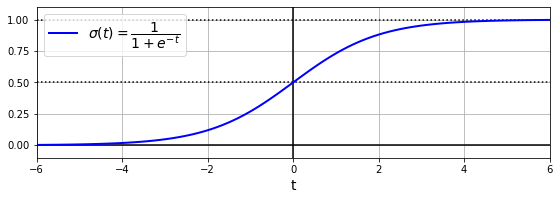

In [47]:
# extra code – generates and saves Figure 4–21

lim = 6
t = np.linspace(-lim, lim, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(8, 3))
plt.plot([-lim, lim], [0, 0], "k-")
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \dfrac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.axis([-lim, lim, -0.1, 1.1])
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid()
plt.show()

### 결정 경계

In [48]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [49]:
print(iris.DESCR)  # extra code – it's a bit too long

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [50]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [51]:
iris.target.head(3)  # note that the instances are not shuffled

0    0
1    0
2    0
Name: target, dtype: int64

In [52]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

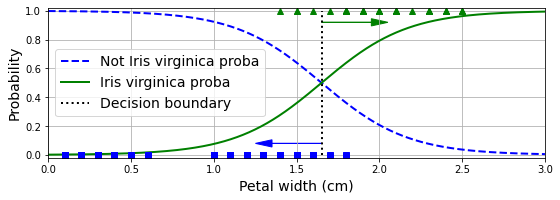

In [54]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)  # reshape to get a column vector
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(8, 3))  # extra code – not needed, just formatting
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

# extra code – this section beautifies and saves Figure 4–21
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()

plt.show()

In [55]:
decision_boundary

1.6516516516516517

In [56]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

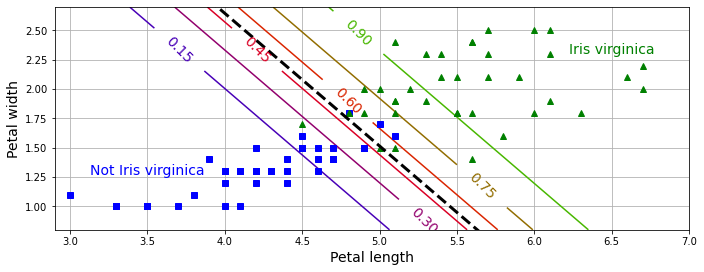

In [57]:
# extra code – this cell generates and saves Figure 4–22

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

# for the contour plot
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # one instance per point on the figure
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# for the decision boundary
left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
plt.show()

### 소프트맥스 회귀

In [58]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

In [59]:
softmax_reg.predict([[5, 2]])

array([2])

In [60]:
softmax_reg.predict_proba([[5, 2]]).round(2)

array([[0.  , 0.04, 0.96]])

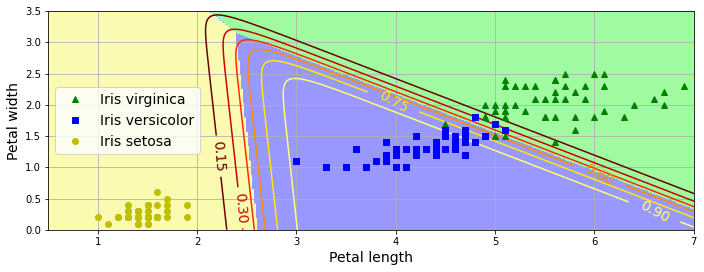

In [61]:
# extra code – this cell generates and saves Figure 4–23

from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
splt.show()

## 연습 문제

## 1. to 11.

1. If you have a training set with millions of features you can use Stochastic Gradient Descent or Mini-batch Gradient Descent, and perhaps Batch Gradient Descent if the training set fits in memory. But you cannot use the Normal Equation or the SVD approach because the computational complexity grows quickly (more than quadratically) with the number of features.
2. If the features in your training set have very different scales, the cost function will have the shape of an elongated bowl, so the Gradient Descent algorithms will take a long time to converge. To solve this you should scale the data before training the model. Note that the Normal Equation or SVD approach will work just fine without scaling. Moreover, regularized models may converge to a suboptimal solution if the features are not scaled: since regularization penalizes large weights, features with smaller values will tend to be ignored compared to features with larger values.
3. Gradient Descent cannot get stuck in a local minimum when training a Logistic Regression model because the cost function is convex. _Convex_ means that if you draw a straight line between any two points on the curve, the line never crosses the curve.
4. If the optimization problem is convex (such as Linear Regression or Logistic Regression), and assuming the learning rate is not too high, then all Gradient Descent algorithms will approach the global optimum and end up producing fairly similar models. However, unless you gradually reduce the learning rate, Stochastic GD and Mini-batch GD will never truly converge; instead, they will keep jumping back and forth around the global optimum. This means that even if you let them run for a very long time, these Gradient Descent algorithms will produce slightly different models.
5. If the validation error consistently goes up after every epoch, then one possibility is that the learning rate is too high and the algorithm is diverging. If the training error also goes up, then this is clearly the problem and you should reduce the learning rate. However, if the training error is not going up, then your model is overfitting the training set and you should stop training.
6. Due to their random nature, neither Stochastic Gradient Descent nor Mini-batch Gradient Descent is guaranteed to make progress at every single training iteration. So if you immediately stop training when the validation error goes up, you may stop much too early, before the optimum is reached. A better option is to save the model at regular intervals; then, when it has not improved for a long time (meaning it will probably never beat the record), you can revert to the best saved model.
7. Stochastic Gradient Descent has the fastest training iteration since it considers only one training instance at a time, so it is generally the first to reach the vicinity of the global optimum (or Mini-batch GD with a very small mini-batch size). However, only Batch Gradient Descent will actually converge, given enough training time. As mentioned, Stochastic GD and Mini-batch GD will bounce around the optimum, unless you gradually reduce the learning rate.
8. If the validation error is much higher than the training error, this is likely because your model is overfitting the training set. One way to try to fix this is to reduce the polynomial degree: a model with fewer degrees of freedom is less likely to overfit. Another thing you can try is to regularize the model—for example, by adding an ℓ₂ penalty (Ridge) or an ℓ₁ penalty (Lasso) to the cost function. This will also reduce the degrees of freedom of the model. Lastly, you can try to increase the size of the training set.
9. If both the training error and the validation error are almost equal and fairly high, the model is likely underfitting the training set, which means it has a high bias. You should try reducing the regularization hyperparameter _α_.
10. Let's see:
  * A model with some regularization typically performs better than a model without any regularization, so you should generally prefer Ridge Regression over plain Linear Regression.
  * Lasso Regression uses an ℓ₁ penalty, which tends to push the weights down to exactly zero. This leads to sparse models, where all weights are zero except for the most important weights. This is a way to perform feature selection automatically, which is good if you suspect that only a few features actually matter. When you are not sure, you should prefer Ridge Regression.
  * Elastic Net is generally preferred over Lasso since Lasso may behave erratically in some cases (when several features are strongly correlated or when there are more features than training instances). However, it does add an extra hyperparameter to tune. If you want Lasso without the erratic behavior, you can just use Elastic Net with an `l1_ratio` close to 1.
11. If you want to classify pictures as outdoor/indoor and daytime/nighttime, since these are not exclusive classes (i.e., all four combinations are possible) you should train two Logistic Regression classifiers.

## 12. Batch Gradient Descent with early stopping for Softmax Regression
Exercise: _Implement Batch Gradient Descent with early stopping for Softmax Regression without using Scikit-Learn, only NumPy. Use it on a classification task such as the iris dataset._

Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.

In [62]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

We need to add the bias term for every instance ($x_0 = 1$). The easiest option to do this would be to use Scikit-Learn's `add_dummy_feature()` function, but the point of this exercise is to get a better understanding of the algorithms by implementing them manually. So here is one possible implementation:

In [63]:
X_with_bias = np.c_[np.ones(len(X)), X]

The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but again, we want to did this manually:

In [64]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

np.random.seed(42)
rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for any given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance. To understand this code, you need to know that `np.diag(np.ones(n))` creates an n×n matrix full of 0s except for 1s on the main diagonal. Moreover, if `a` in a NumPy array, then `a[[1, 3, 2]]` returns an array with 3 rows equal to `a[1]`, `a[3]` and `a[2]` (this is [advanced NumPy indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#advanced-indexing)).

In [65]:
def to_one_hot(y):
    return np.diag(np.ones(y.max() + 1))[y]

Let's test this function on the first 10 instances:

In [66]:
y_train[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

In [67]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [68]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

Now let's scale the inputs. We compute the mean and standard deviation of each feature on the training set (except for the bias feature), then we center and scale each feature in the training set, the validation set, and the test set:

In [69]:
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [70]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps / exp_sums

We are almost ready to start training. Let's define the number of inputs and outputs:

In [71]:
n_inputs = X_train.shape[1]  # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))  # == 3 (there are 3 iris classes)

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [72]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        print(epoch, xentropy_losses.sum(axis=1).mean())
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    Theta = Theta - eta * gradients

0 3.7085808486476917
1000 0.14519367480830644
2000 0.1301309575504088
3000 0.12009639326384539
4000 0.11372961364786884
5000 0.11002459532472425


And that's it! The Softmax model is trained. Let's look at the model parameters:

In [73]:
Theta

array([[ 0.41931626,  6.11112089, -5.52429876],
       [-6.53054533, -0.74608616,  8.33137102],
       [-5.28115784,  0.25152675,  6.90680425]])

Let's make predictions for the validation set and check the accuracy score:

In [74]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

Well, this model looks pretty ok. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [75]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5
alpha = 0.01  # regularization hyperparameter

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
        total_loss = xentropy_losses.sum(axis=1).mean() + alpha * l2_loss
        print(epoch, total_loss.round(4))
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
1000 0.3259
2000 0.3259
3000 0.3259
4000 0.3259
5000 0.3259


Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:

In [76]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

In this case, the $\ell_2$ penalty did not change the test accuracy. Perhaps try fine-tuning `alpha`?

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [77]:
eta = 0.5
n_epochs = 50_001
m = len(X_train)
epsilon = 1e-5
C = 100  # regularization hyperparameter
best_loss = np.infty

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
    if epoch % 1000 == 0:
        print(epoch, total_loss.round(4))
    if total_loss < best_loss:
        best_loss = total_loss
    else:
        print(epoch - 1, best_loss.round(4))
        print(epoch, total_loss.round(4), "early stopping!")
        break
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
281 0.3256
282 0.3256 early stopping!


In [78]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

Oh well, still no change in validation acccuracy, but at least early training shortened training a bit.

Now let's plot the model's predictions on the whole dataset (remember to scale all features fed to the model):

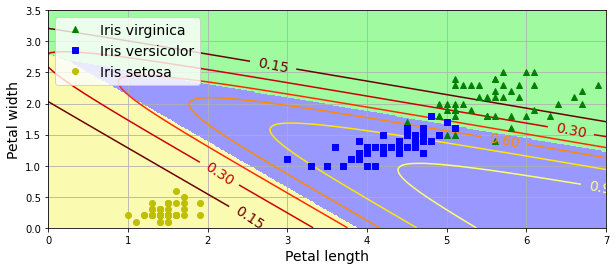

In [79]:
custom_cmap = mpl.colors.ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

And now let's measure the final model's accuracy on the test set:

In [80]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

0.9666666666666667

Well we get even better performance on the test set. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.